In [1]:
import warnings
warnings.filterwarnings("ignore")
from keras.engine.topology import Layer
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, GRU, Multiply, Reshape
from keras.layers import RepeatVector, Dense, Activation, Lambda, Embedding
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import keras
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import pandas as pd
# from tcn import TCN
%matplotlib inline
from keras.layers import merge, Input, Dense, TimeDistributed, Lambda                                   
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, GlobalMaxPooling2D,MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Input, GlobalAveragePooling2D,AveragePooling2D, Add
from keras.optimizers import Adam, rmsprop
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.constraints import maxnorm
MAX_SENT_LENGTH = 55
MAX_SENTS = 24
VALIDATION_SPLIT = 0.2

Using TensorFlow backend.


In [2]:
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler  
from pandas import concat

std = StandardScaler()

In [3]:
import pandas as pd
#matplotlib inline
#参数初始化
discfile = '../data/data_wea_time_unify.csv'

data = pd.read_csv(discfile)

In [4]:
futrue_time=24

time_step=24

In [5]:
for i in range(24,96):
    data['PM25_m'+str(i)]=data['PM25_mean'].shift(-i)
data=data.dropna(how='any')

In [6]:
target_data=data.iloc[:,76:]
source_data=data.iloc[:,4:58]

import copy
sd=copy.deepcopy(source_data)
td=copy.deepcopy(target_data)

td=td.dropna(how='any')
# td=std.fit_transform(td)
sd=std.fit_transform(sd)
# sd=sd.values
td=td.values
td_test=td[5801:,:futrue_time]   
td=td[:5801,:futrue_time]
sd_m=[]
for i in range(1,MAX_SENTS+1):
    locals()['sd'+str(i)]=sd[i-1:5800+i]

    sd_m.append(locals()['sd'+str(i)])
sd_m=(np.array(sd_m).swapaxes(0,1))


######test
sd_m_test=[]
for i in range(1,25):
    locals()['sd_t'+str(i)]=sd[5800+i:5969-24+i]
    
    sd_m_test.append(locals()['sd_t'+str(i)])

sd_m_test=(np.array(sd_m_test).swapaxes(0,1))

In [7]:
wea_data=data.iloc[:,67:75]
# wea_data=std.fit_transform(wea_data)
# wea_data=pd.DataFrame(wea_data)
w=wea_data[['Conditions','Wind Dir','Quality evaluation']]
# w=std.fit_transform(w)
w_m=[]
for i in range(1,25):
    locals()['w'+str(i)]=w[i-1:5800+i].values
    
    w_m.append(locals()['w'+str(i)])
    
wea=wea_data[['Dew Point','Humidity','Pressure','Temp.','Wind Speed']]
wea=std.fit_transform(wea)
wea_m=[]
for i in range(1,25):
    locals()['wea'+str(i)]=wea[i-1:5800+i]
    
    wea_m.append(locals()['wea'+str(i)])

In [8]:
time_data=data.iloc[:,64:67]
# time_data=std.fit_transform(time_data)
time_m=[]
for i in range(1,25):
    locals()['time'+str(i)]=time_data[i-1:5800+i].values
    
    time_m.append(locals()['time'+str(i)])

In [17]:
time_m=(np.array(time_m).swapaxes(0,1))
w_m=(np.array(w_m).swapaxes(0,1))
wea_m=(np.array(wea_m).swapaxes(0,1))

In [18]:
time_m_test=[]
for i in range(1,25):
    locals()['time_t'+str(i)]=time_data[5800+i:5969-24+i].values
    
    time_m_test.append(locals()['time_t'+str(i)])

time_m_test=(np.array(time_m_test).swapaxes(0,1))

w_m_test=[]
for i in range(1,25):
    locals()['w_t'+str(i)]=w[5800+i:5969-24+i].values
    
    w_m_test.append(locals()['w_t'+str(i)])

w_m_test=(np.array(w_m_test).swapaxes(0,1))

wea_m_test=[]
for i in range(1,25):
    locals()['wea_t'+str(i)]=wea[5800+i:5969-24+i]
    
    wea_m_test.append(locals()['wea_t'+str(i)])

wea_m_test=(np.array(wea_m_test).swapaxes(0,1))

In [19]:
import h5py
import os

ground = h5py.File('../data/inte_g_12_linear.h5', 'r')
g = ground['X']

ele_zs = h5py.File('../data/inte_e_zs_12_new_linear.h5', 'r')
ezs = ele_zs['X']

ele_sd = h5py.File('../data/inte_e_sd_12_new_linear.h5', 'r')
esd = ele_sd['X']

g_m=[]
for i in range(1,25):
    locals()['g'+str(i)]=g[i-1:5800+i]
    
    g_m.append(locals()['g'+str(i)])
g_m=(np.array(g_m).swapaxes(0,1))
g_m=g_m.reshape(5801, 24, 16,16,1)

ezs_m=[]
for i in range(1,25):
    locals()['ezs'+str(i)]=ezs[i-1:5800+i]
    
    ezs_m.append(locals()['ezs'+str(i)])
ezs_m=(np.array(ezs_m).swapaxes(0,1))

ezs_m=ezs_m.reshape(5801, 24, 16,16,1)

esd_m=[]
for i in range(1,25):
    locals()['esd'+str(i)]=esd[i-1:5800+i]
    
    esd_m.append(locals()['esd'+str(i)])
esd_m=(np.array(esd_m).swapaxes(0,1))

esd_m=esd_m.reshape(5801, 24, 16,16,1)

ge_m=[ezs_m,esd_m,g_m]

ge_m=np.array(ge_m).reshape(5801, 24, 16,16,3)

In [20]:
#####test
g_m_test=[]
for i in range(1,25):
    locals()['g_t'+str(i)]=g[5800+i:5969-24+i]
    
    g_m_test.append(locals()['g_t'+str(i)])
g_m_test=(np.array(g_m_test).swapaxes(0,1))

g_m_test=g_m_test.reshape(145, 24, 16,16,1)

ezs_m_test=[]
for i in range(1,25):
    locals()['ezs_t'+str(i)]=ezs[5800+i:5969-24+i]
    
    ezs_m_test.append(locals()['ezs_t'+str(i)])
ezs_m_test=(np.array(ezs_m_test).swapaxes(0,1))

ezs_m_test=ezs_m_test.reshape(145, 24, 16,16,1)

esd_m_test=[]
for i in range(1,25):
    locals()['esd_t'+str(i)]=esd[5800+i:5969-24+i]
    
    esd_m_test.append(locals()['esd_t'+str(i)])
esd_m_test=(np.array(esd_m_test).swapaxes(0,1))

esd_m_test=esd_m_test.reshape(145, 24, 16,16,1)
ge_m_test=[ezs_m_test,esd_m_test,g_m_test]

ge_m_test=np.array(ge_m_test).reshape(145, 24, 16,16,3)

Train on 4640 samples, validate on 1161 samples
Epoch 1/20
 - 120s - loss: 39.2311 - val_loss: 24.9460
Epoch 2/20
 - 118s - loss: 27.8868 - val_loss: 23.9127
Epoch 3/20
 - 118s - loss: 26.7415 - val_loss: 22.9288
Epoch 4/20
 - 118s - loss: 25.4892 - val_loss: 22.4538
Epoch 5/20
 - 118s - loss: 24.4409 - val_loss: 21.5321
Epoch 6/20
 - 118s - loss: 23.8301 - val_loss: 21.0393
Epoch 7/20
 - 118s - loss: 23.2929 - val_loss: 21.1667
Epoch 8/20
 - 117s - loss: 22.9370 - val_loss: 20.1589
Epoch 9/20
 - 118s - loss: 22.6001 - val_loss: 19.8322
Epoch 10/20
 - 119s - loss: 22.2903 - val_loss: 19.7198
Epoch 11/20
 - 118s - loss: 22.1396 - val_loss: 19.5130
Epoch 12/20
 - 118s - loss: 21.8466 - val_loss: 19.1255
Epoch 13/20
 - 118s - loss: 21.6432 - val_loss: 19.0745
Epoch 14/20
 - 119s - loss: 21.3429 - val_loss: 18.9673
Epoch 15/20
 - 118s - loss: 21.1874 - val_loss: 18.7513
Epoch 16/20
 - 118s - loss: 21.0630 - val_loss: 18.8755
Epoch 17/20
 - 118s - loss: 20.9680 - val_loss: 18.5518
Epoch 18/

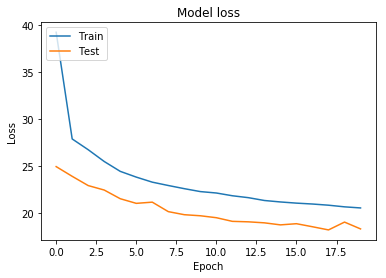

In [31]:
# from attention_keras import *
from keras.layers import LeakyReLU
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(** kwargs)
    
    def build(self, input_shape):
        assert len(input_shape)==3
        # W.shape = (time_steps, time_steps)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[1], input_shape[1]),
                                 initializer='uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, mask=None):
        x = K.permute_dimensions(inputs, (0, 2, 1))
        # x.shape = (batch_size, seq_len, time_steps)
        # general
        a = K.softmax(K.tanh(K.dot(x, self.W)))
        a = K.permute_dimensions(a, (0, 2, 1))
        outputs = a * inputs
        outputs = K.sum(outputs, axis=1)
        return outputs

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

def create_model(learn_rate=0.001, neurons=24, traffic_n=3):
#     时间戳模块    
    inp_time=Input(shape=(3,))
    inp_time1 = Reshape((3,1))(inp_time)
    embed_time = Dense(3)(inp_time1)
#     embed_time = Embedding(24,3, input_length=3)(inp_time)
#     embed_time=BatchNormalization()(embed_time)
    embed_time=Flatten()(embed_time)
    embed_time=BatchNormalization()(embed_time)
    tm=Model(inputs=inp_time, outputs=embed_time)
    
#     离散型气象数据模块
    inp_w=Input(shape=(3,))
    embed_w = Reshape((3,1))(inp_w)
    embed_w1 = Dense(3)(embed_w)
#     embed_w1 = Dense(3)(embed_w1)
#     embed_w = Embedding(18, 2, input_length=3)(inp_w)
#     embed_w = AttentionLayer()(embed_w)
    embed_w2=Flatten()(embed_w1)
    embed_w3=BatchNormalization()(embed_w2)
    wm=Model(inputs=inp_w, outputs=embed_w3)
    
#     连续型气象数据模块
    inp_we=Input(shape=(5,))
#     embed_we = Reshape((5,1))(inp_we)
    embed_we=BatchNormalization()(inp_we)
    embed_we = Dense(5)(inp_we)
#     embed_we = AttentionLayer()(embed_we)
#     input_we_time=keras.layers.concatenate([embed_time,embed_w,embed_we])
    weam=Model(inputs=inp_we, outputs=embed_we)
    
    
#     交通指数数据模块
    inp=Input(shape=(16, 16, 3))
    out=Conv2D(filters=1, kernel_size=2, strides=1)(inp)
#     print(out.shape)
    out=BatchNormalization()(out)
    out=LeakyReLU('0.1')(out)
#     out=Activation('relu')(out)
    # out=MaxPooling2D(pool_size=(3, 3), strides=2)(out)
    # print(out.shape)
    out=AveragePooling2D()(out)
#     out=GlobalAveragePooling2D()(out)
    out=Flatten()(out)
    out=Dense(traffic_n)(out)
    tra=Model(inputs=inp, outputs=out)
    
#     特征组件
    sentence_input = Input(shape=(54+traffic_n,))
    # s_input=keras.layers.concatenate([sentence_input])
    embed = Reshape((54+traffic_n,1))(sentence_input)
    l_lstm=MAttention(8,16)([embed,embed,embed])
#     l_lstm = Bidirectional(GRU(32, return_sequences=True))(embed)
#     embed = Reshape((54+traffic_n,1))(l_lstm)
    l_dense = TimeDistributed(Dense(32))(l_lstm)
#     l_dense = Bidirectional(GRU(32, return_sequences=True))(l_lstm)

    l_att = AttentionLayer()(l_dense)

    sentEncoder = Model(sentence_input, l_att)

    
    review_input = Input(shape=(MAX_SENTS,54))
    r_input = Input(shape=(MAX_SENTS,16, 16, 3))
    r_encoder = TimeDistributed(tra)(r_input)
    s_input=keras.layers.concatenate([r_encoder,review_input])
    
    review_encoder = TimeDistributed(sentEncoder)(s_input)
    
#     time_input=Input(shape=(MAX_SENTS,3))
#     t_encoder = TimeDistributed(tm)(time_input)

    w_input=Input(shape=(MAX_SENTS,3))
    w_encoder = TimeDistributed(wm)(w_input)

    wea_input=Input(shape=(MAX_SENTS,5))
    wea_encoder = TimeDistributed(weam)(wea_input)
#     we_time_encoder=keras.layers.concatenate([wea_input,review_encoder])
#     we_time_encoder=keras.layers.concatenate([t_encoder,w_encoder,wea_input,review_encoder])

#     l_lstm_sent = Bidirectional(GRU(50, return_sequences=True))(we_time_encoder)

#     l_lstm_sent = Bidirectional(GRU(32, return_sequences=True))(review_encoder)
    l_lstm_sent=TCN(padding='same',return_sequences=True)(review_encoder)
#     review_encoder = Position_Embedding()(review_encoder) # 增加Position_Embedding能轻微提高准确率
#     l_lstm_sent=Attention(8,16)([review_encoder,review_encoder,review_encoder])
    we_time_encoder=keras.layers.concatenate([w_encoder,wea_input,l_lstm_sent])

    l_dense_sent = TimeDistributed(Dense(64))(we_time_encoder)
#     l_dense_sent = TCN(padding='same',return_sequences=True)(we_time_encoder)
#     l_dense_sent = Bidirectional(GRU(32, return_sequences=True))(we_time_encoder)
#     l_dense_sent = TimeDistributed(Dense(64))(we_time_encoder)
    l_att_sent = AttentionLayer()(l_dense_sent)
    preds = Dense(futrue_time)(l_att_sent)
    model_1 = Model([w_input,wea_input,r_input,review_input], preds)
    model_1.compile(optimizer=Adam(lr=learn_rate, beta_1=0.99, beta_2=0.999, decay=0.0006),
                        loss='mae')
    return model_1

model=create_model()
history=model.fit([w_m,wea_m,ge_m,sd_m],td, epochs=20, batch_size=68,verbose=2,validation_split=0.2,shuffle=True)
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [194]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           (None, 24, 16, 16, 3 0                                            
__________________________________________________________________________________________________
time_distributed_33 (TimeDistri (None, 24, 3)        167         input_53[0][0]                   
__________________________________________________________________________________________________
input_52 (InputLayer)           (None, 24, 54)       0                                            
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 24, 57)       0           time_distributed_33[0][0]        
                                                                 input_52[0][0]                   
__________

In [32]:
pre_test=model.predict([w_m_test,wea_m_test,ge_m_test,sd_m_test])

import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(np.round(mean_absolute_error(pre_test,td_test[:145]),3),np.round(np.sqrt(mean_squared_error(pre_test,td_test[:145])),3))
# mean_absolute_error(pre_test,td_test[:145]),np.sqrt(mean_squared_error(pre_test,td_test[:145]))


17.29 22.509


In [33]:
from keras.models import load_model

model.save('new_LRP_norm03_model_17.29_22.509new_At_TCN.h5')  # creates a HDF5 file 'my_model.h5'

# returns a compiled model
# identical to the previous one
# model = load_model('air_traff_model.h5',custom_objects={'AttentionLayer': AttentionLayer})

In [176]:
# f = K.function(model.inputs, [model.get_layer('dense_21').get_output_at(0) for t in range(24)])
# f = K.function(model.inputs, [model.get_layer('attention_weights3').output])

f = K.function(model.inputs, [model.get_layer('concatenate_8').output])

t=22

# r = f([time_m_test[1].reshape(1,24,3),w_m_test[1].reshape(1,24,3),wea_m_test[1].reshape(1,24,5),ge_m_test[1].reshape(1,24,16,16,3),sd_m_test[1].reshape(1,24,55)])

# r = f([time_m_test[t].reshape(1,24,3),w_m_test[t].reshape(1,24,3),wea_m_test[t].reshape(1,24,5),ge_m_test[t].reshape(1,24,16,16,3),sd_m_test[t].reshape(1,24,54)])
r = f([w_m_test[t].reshape(1,24,3),wea_m_test[t].reshape(1,24,5),ge_m_test[t].reshape(1,24,16,16,3),sd_m_test[t].reshape(1,24,54)])

# r = f([time_m,w_m,wea_m,ge_m,sd_m])



In [177]:
r[0][0][0]

array([ 0.32682979,  0.54507756, -0.30751556,  1.10538816,  1.30223846,
       -1.37183332, -0.1928184 , -0.03377199,  0.04389238,  0.1201181 ,
        1.00378025, -1.24483192, -0.3540802 ,  2.27805638,  0.        ,
        3.76776481,  1.7313453 ,  1.66965914,  3.3993721 ,  2.37434125,
        5.13138437,  0.30587277,  3.84024286,  3.69034266,  0.        ,
        0.38770697,  0.        ,  0.        ,  2.39867377,  0.        ,
        0.        ,  0.75867277,  0.        ,  2.85236025,  0.        ,
        0.        ,  3.45588541,  0.99129105,  3.01035452,  0.        ,
        4.88146067,  3.38616037,  5.81438255,  1.3623929 ,  0.01638078,
        0.        ,  0.        ,  5.46834517,  0.48497123,  0.58318943,
        0.        ,  4.86927605,  3.92084479,  4.39471245,  0.02253062,
        0.02326581,  2.97521138,  0.        ,  0.        ,  0.79415482,
        1.98963976,  4.26739645,  3.48198771,  3.11769938,  1.03383303,
        5.45237446,  1.79314458,  3.11861682,  0.        ,  0.  

In [34]:
import innvestigate

In [35]:
# analyzer = innvestigate.create_analyzer("lrp.z", model, allow_lambda_layers = True)
analyzer = innvestigate.create_analyzer("lrp.z", model, allow_lambda_layers = True)

In [36]:
np.shape(sd_m[0])

(24, 54)

In [37]:
# w=wea_data[['Conditions','Wind Dir','Quality evaluation']]
# wea=wea_data[['Dew Point','Humidity','Pressure','Temp.','Wind Speed']]

tem=sd_m[0].reshape(1,24,54)
tem1=ge_m[0].reshape(1,24, 16, 16, 3)
# tem2=time_m[0].reshape(1,24, 3)
tem3=w_m[0].reshape(1,24, 3)
tem4=wea_m[0].reshape(1,24,5)

In [38]:
# analysis = analyzer.analyze([tem2,tem3,tem4,tem1,tem])
analysis = analyzer.analyze([tem3,tem4,tem1,tem])


In [56]:
a=analysis[0]

In [57]:
a.shape

(1, 24, 3)

In [58]:
np.asarray(a.shape) == 3

array([False, False,  True], dtype=bool)

In [59]:
np.argmax(np.asarray(a.shape) == 3)

2

In [60]:
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 1))

In [61]:
a

array([[ -1.04182623e-02,   5.28117418e+00,  -6.08038545e-01],
       [ -1.67054217e-03,  -6.72920942e+00,   3.37233245e-01],
       [ -9.52232629e-04,  -5.78067875e+00,   2.92808175e-01],
       [ -6.56509772e-03,   7.09324884e+00,  -6.49740934e-01],
       [ -7.85826705e-04,   9.72558689e+00,  -6.61975443e-01],
       [ -7.22478796e-03,   8.13113022e+00,  -7.27059603e-01],
       [  1.74690038e-03,  -4.89258862e+00,   3.05374265e-01],
       [ -1.50623918e-03,   9.49139023e+00,  -7.03078747e-01],
       [ -2.57897098e-03,  -6.49780273e+00,   3.20141435e-01],
       [ -2.61562131e-03,  -6.46373034e+00,   3.25504422e-01],
       [ -1.42688304e-03,  -6.14520836e+00,   3.09810936e-01],
       [  5.41683286e-04,  -5.97015381e+00,   3.53190660e-01],
       [  1.81923062e-03,  -6.02963924e+00,   3.69686753e-01],
       [  2.18932703e-03,  -5.72592258e+00,   3.54393303e-01],
       [  2.76733423e-03,  -5.81792450e+00,   3.56465459e-01],
       [  4.10019327e-03,  -5.59879208e+00,   3.7199616

In [66]:
np.max(np.abs(a),axis=0)

array([  0.0260875 ,  20.15694427,   0.78494155], dtype=float32)

In [67]:

# a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a),axis=0)

In [69]:
a

array([[-0.39935836,  0.26200271, -0.77462906],
       [-0.06403611, -0.33384076,  0.42962849],
       [-0.03650149, -0.28678349,  0.37303182],
       [-0.25165683,  0.35190099, -0.82775706],
       [-0.03012273,  0.48249313, -0.84334362],
       [-0.27694443,  0.403391  , -0.92625952],
       [ 0.06696311, -0.24272472,  0.38904077],
       [-0.05773796,  0.47087446, -0.89570838],
       [-0.09885849, -0.32236052,  0.40785384],
       [-0.10026339, -0.32067016,  0.4146862 ],
       [-0.05469604, -0.30486804,  0.39469299],
       [ 0.02076409, -0.29618347,  0.44995791],
       [ 0.06973571, -0.29913458,  0.47097361],
       [ 0.08392245, -0.284067  ,  0.45149004],
       [ 0.10607893, -0.28863126,  0.45412993],
       [ 0.15717079, -0.27775997,  0.47391576],
       [ 0.07833501,  0.50711858, -0.83008128],
       [ 0.17064388,  0.53887719, -0.82073641],
       [ 0.21645081,  0.56458974, -0.83551031],
       [ 0.34136781,  0.59305441, -0.79889721],
       [ 0.50437343,  0.67117411, -0.818

In [72]:
np.shape(a)

(24, 3)

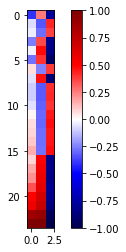

In [73]:
plt.imshow(a, cmap="seismic", clim=(-1, 1))
plt.colorbar()
plt.show()

In [50]:
a

array([[ -5.16857253e-04,   2.62002707e-01,  -3.01652141e-02],
       [ -8.28767588e-05,  -3.33840758e-01,   1.67303756e-02],
       [ -4.72409229e-05,  -2.86783487e-01,   1.45264165e-02],
       [ -3.25699046e-04,   3.51900995e-01,  -3.22340988e-02],
       [ -3.89854067e-05,   4.82493132e-01,  -3.28410603e-02],
       [ -3.58426740e-04,   4.03391004e-01,  -3.60699333e-02],
       [  8.66649425e-05,  -2.42724717e-01,   1.51498290e-02],
       [ -7.47255690e-05,   4.70874459e-01,  -3.48802246e-02],
       [ -1.27944542e-04,  -3.22360516e-01,   1.58824380e-02],
       [ -1.29762790e-04,  -3.20670158e-01,   1.61485001e-02],
       [ -7.07886575e-05,  -3.04868042e-01,   1.53699359e-02],
       [  2.68732838e-05,  -2.96183467e-01,   1.75220333e-02],
       [  9.02532920e-05,  -2.99134582e-01,   1.83404163e-02],
       [  1.08614033e-04,  -2.84067005e-01,   1.75816976e-02],
       [  1.37289375e-04,  -2.88631260e-01,   1.76844988e-02],
       [  2.03413438e-04,  -2.77759969e-01,   1.8454987

In [51]:
from IPython.display import display, HTML
from heatmap import html_heatmap

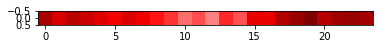

In [204]:
a0=analysis[0]
a0 = a0.sum(axis=np.argmax(np.asarray(a0.shape) == 3))
a0 /= np.max(np.abs(a0))
plt.imshow(a0, cmap="seismic", clim=(-1, 1))

In [77]:
a1.shape

(24, 5)

In [76]:
np.asarray(a1.shape) == 3

array([False, False], dtype=bool)

In [80]:
np.shape(a1)

(1, 24, 5)

In [86]:
analysis[1]

array([[[-1.,  1., -1., -1., -1.],
        [ 1., -1., -1.,  1.,  1.],
        [ 1., -1., -1.,  1.,  1.],
        [-1.,  1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1.],
        [ 1., -1., -1.,  1.,  1.],
        [-1.,  1., -1., -1., -1.],
        [ 1., -1., -1.,  1.,  1.],
        [ 1., -1., -1.,  1.,  1.],
        [ 1., -1., -1.,  1.,  1.],
        [ 1., -1., -1.,  1.,  1.],
        [ 1., -1., -1.,  1.,  1.],
        [ 1., -1., -1.,  1.,  1.],
        [ 1., -1., -1.,  1.,  1.],
        [ 1., -1., -1.,  1.,  1.],
        [-1.,  1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1.]]], dtype=float32)

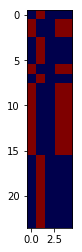

In [87]:
a1=analysis[1]
a1 = a1.sum(axis=np.argmax(np.asarray(a1.shape) == 1))
a1 /= np.max(np.abs(a1),axis=0)
plt.imshow(a1, cmap="seismic", clim=(-1, 1))

In [184]:
temp=analysis[2].sum(axis=np.argmax(np.asarray(analysis[2].shape) == 24))/ np.max(np.abs(analysis[2]))
# np.shape(temp[0].reshape( 3,16, 16)[0])
np.shape(temp[0])

(16, 16, 3)

In [163]:
np.max(np.abs(analysis[2]))

0.00014808623

In [164]:
temp[0].reshape( 3,16, 16)[0]

array([[ -2.30955146e-03,   7.08404754e-04,  -6.77420059e-04,
         -5.31641440e-03,   1.77428150e-03,  -1.27566198e-03,
         -5.78096928e-03,   1.91679865e-03,  -1.41191145e-03,
         -6.38575014e-03,   2.13121623e-03,  -1.53223274e-03,
         -4.71878191e-03,   1.61989254e-03,  -1.04331074e-03,
         -1.21665925e-01],
       [  3.73870470e-02,  -3.55497859e-02,  -1.13603197e-01,
          4.23216447e-02,  -1.85526907e-02,   9.87947062e-02,
         -3.29720043e-02,   2.37053782e-02,   5.58360815e-02,
         -1.97954308e-02,   1.11051984e-02,  -8.54035665e-04,
          2.64445902e-04,  -2.45569507e-04,  -1.73314777e-03,
          5.81467466e-04],
       [ -4.09852684e-04,   1.18807727e-03,  -3.21553904e-04,
          4.33138863e-04,  -3.32061425e-02,   1.00555345e-02,
         -9.99584794e-03,  -4.78873551e-02,   1.69222169e-02,
         -9.63333249e-03,  -1.45979191e-03,   5.17480599e-04,
         -2.90440454e-04,   0.00000000e+00,   0.00000000e+00,
          0.0000

In [88]:
a2=analysis[2]
a2 = a2.sum(axis=np.argmax(np.asarray(a2.shape) == 3))
a2 /= np.max(np.abs(a2))
plt.imshow(a2[0].reshape( 3,16, 16)[2], cmap="seismic", clim=(-1, 1))

ValueError: cannot reshape array of size 6144 into shape (3,16,16)

In [89]:
a3=analysis[2]
a3 = a3.sum(axis=np.argmax(np.asarray(a3.shape) == 3))
a3 /= np.max(np.abs(a3))

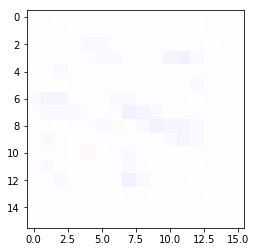

In [90]:
plt.imshow(a3[0][12], cmap="seismic", clim=(-1, 1))

In [235]:
np.shape(ge_m[0][0])
aaaa=tem1[0][0]
aaaa /= np.max(np.abs(tem1[0][0]))

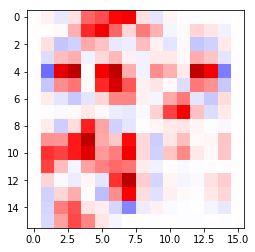

In [236]:
plt.imshow(aaaa.reshape( 3,16, 16)[0], cmap="seismic", clim=(-1, 1))

In [99]:
np.shape(analysis[2])

(1, 24, 16, 16, 3)

In [103]:
np.max(np.abs(a3),axis=1)

array([[[  1.25297345e-02,   2.16839537e-02,   3.18921841e-04,
           1.63942166e-02,   7.71892164e-03,   1.57095924e-01,
           7.85982385e-02,   2.35570632e-02,   4.31323871e-02,
           7.82308504e-02,   2.95233522e-02,   3.75895053e-02,
           7.97957554e-03,   3.04818824e-02,   1.28684044e-02,
           0.00000000e+00],
        [  1.17692411e-01,   1.03894301e-01,   1.28580891e-02,
           1.62599161e-02,   6.78224629e-03,   5.48432618e-02,
           8.63304362e-02,   3.86476032e-02,   9.78965983e-02,
           8.71954635e-02,   5.84455095e-02,   1.84044298e-02,
           6.59226403e-02,   1.88753486e-01,   1.39124826e-01,
           0.00000000e+00],
        [  5.84399067e-02,   9.71426070e-02,   1.49832621e-01,
           1.02954455e-01,   2.67310292e-01,   4.71843541e-01,
           2.29689524e-01,   3.33428085e-02,   8.57935324e-02,
           2.91456819e-01,   5.13640106e-01,   3.86272132e-01,
           4.68501225e-02,   7.80440792e-02,   1.12184308e-01,

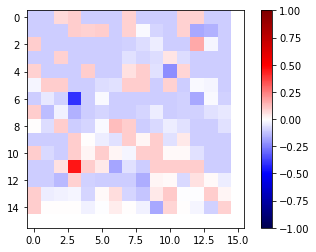

In [109]:
a3=analysis[2]
a3 = a3.sum(axis=np.argmax(np.asarray(a3.shape) == 3))
a3 /= np.max(np.abs(a3),axis=1)
# plt.imshow(a3, cmap="seismic", clim=(-1, 1))
# for i in range(24):
plt.imshow(a3[0][22], cmap="seismic", clim=(-1, 1))
plt.colorbar()
plt.show()

In [72]:
a4[0]

array([ 0.54542023,  0.57280326,  0.55741411,  0.57771832,  0.54373825,
        0.56012601,  0.57107681,  0.67498314,  0.53773439,  0.51392424,
        0.5373767 ,  0.54387432,  0.59930599,  0.5904485 ,  0.51380193,
        0.53012234,  0.54785943,  0.54836625,  0.69688088,  0.66262096,
        0.56907833,  0.61679125,  0.63201761,  0.59093076,  0.66319609,
        0.6526587 ,  0.59249604,  0.52867889,  0.53133935,  0.50027472,
        0.48201811,  0.53025818,  0.48370934,  0.526034  ,  0.50285012,
        0.52767736,  0.5644325 ,  0.58794188,  0.63757896,  0.66826689,
        0.58520281,  0.61605316,  0.59635681,  0.5669595 ,  0.61807096,
        0.56563544,  0.5251984 ,  0.44894886,  0.58414102,  0.68314332,
        0.59698343,  0.62983155,  0.57871026,  0.58209383], dtype=float32)

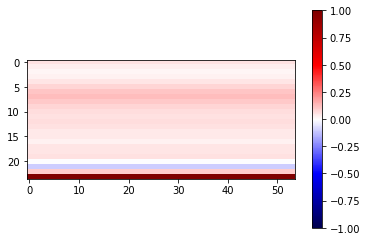

In [206]:
a4=analysis[3]
a4 = a4.sum(axis=np.argmax(np.asarray(a4.shape) == 3))
a4 /= np.max(np.abs(a4))
plt.imshow(a4, cmap="seismic", clim=(-1, 1))
plt.colorbar()
plt.show()
# for j in range(24):
#     display(HTML(html_heatmap([str(i) for i in range(54)], a4[j])))


In [82]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

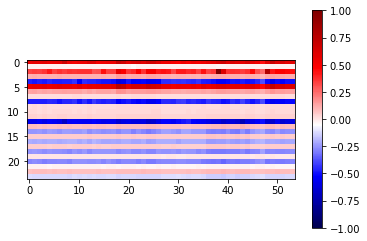

In [91]:
elev_min=-1
elev_max=1
mid_val=-0.05
cmap=matplotlib.cm.RdBu_r # set the colormap to soemthing diverging
plt.imshow(a4, cmap="seismic", clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
plt.colorbar()
plt.show()

In [11]:
import keras.backend as K
import keras.layers
from keras import optimizers
from keras.engine.topology import Layer
from keras.layers import Activation, Lambda
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Convolution1D, Dense
from keras.models import Input, Model
from typing import List, Tuple


def channel_normalization(x):
    # type: (Layer) -> Layer
    """ Normalize a layer to the maximum activation

    This keeps a layers values between zero and one.
    It helps with relu's unbounded activation

    Args:
        x: The layer to normalize

    Returns:
        A maximal normalized layer
    """
    max_values = K.max(K.abs(x), 2, keepdims=True) + 1e-5
    out = x / max_values
    return out


def wave_net_activation(x):
    # type: (Layer) -> Layer
    """This method defines the activation used for WaveNet

    described in https://deepmind.com/blog/wavenet-generative-model-raw-audio/

    Args:
        x: The layer we want to apply the activation to

    Returns:
        A new layer with the wavenet activation applied
    """
    tanh_out = Activation('tanh')(x)
    sigm_out = Activation('sigmoid')(x)
    return keras.layers.multiply([tanh_out, sigm_out])


def residual_block(x, s, i, c, activation, nb_filters, kernel_size, padding, dropout_rate=0):
    # type: (Layer, int, int, int, str, int, int, str, float, str) -> Tuple[Layer, Layer]
    """Defines the residual block for the WaveNet TCN

    Args:
        x: The previous layer in the model
        s: The stack index i.e. which stack in the overall TCN
        i: The dilation power of 2 we are using for this residual block
        c: The dilation name to make it unique. In case we have same dilation twice: [1, 1, 2, 4].
        activation: The name of the type of activation to use
        nb_filters: The number of convolutional filters to use in this block
        kernel_size: The size of the convolutional kernel
        padding: The padding used in the convolutional layers, 'same' or 'causal'.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        name: Name of the model. Useful when having multiple TCN.

    Returns:
        A tuple where the first element is the residual model layer, and the second
        is the skip connection.
    """

    original_x = x
    conv = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding=padding)(x)
    if activation == 'norm_relu':
        x = Activation('relu')(conv)
        x = Lambda(channel_normalization)(x)
    elif activation == 'wavenet':
        x = wave_net_activation(conv)
    else:
        x = Activation(activation)(conv)

    x = SpatialDropout1D(dropout_rate)(x)

    # 1x1 conv.
    x = Convolution1D(nb_filters, 1, padding='same')(x)
    res_x = keras.layers.add([original_x, x])
    return res_x, x


def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        # print(f'Updated dilations from {dilations} to {new_dilations} because of backwards compatibility.')
        return new_dilations


class TCN:
    """Creates a TCN layer.

        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).

        Args:
            nb_filters: The number of filters to use in the convolutional layers.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            activation: The activations to use (norm_relu, wavenet, relu...).
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            name: Name of the model. Useful when having multiple TCN.

        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=[1, 2, 4, 8, 16, 32],
                 activation='norm_relu',
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=True):
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.activation = activation
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.padding = padding

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

        if not isinstance(nb_filters, int):
            print('An interface change occurred after the version 2.1.2.')
            print('Before: tcn.TCN(i, return_sequences=False, ...)')
            print('Now should be: tcn.TCN(return_sequences=False, ...)(i)')
            print('Second solution is to pip install keras-tcn==2.1.2 to downgrade.')
            raise Exception()

    def __call__(self, inputs):
        x = inputs
        x = Convolution1D(self.nb_filters, 1, padding=self.padding)(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for i, d in enumerate(self.dilations):
                x, skip_out = residual_block(x, s, d, i, self.activation, self.nb_filters,
                                             self.kernel_size, self.padding, self.dropout_rate)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = keras.layers.add(skip_connections)
        x = Activation('relu')(x)

        if not self.return_sequences:
            output_slice_index = -1
            x = Lambda(lambda tt: tt[:, output_slice_index, :])(x)
        return x


def compiled_tcn(num_feat,  # type: int
                 num_classes,  # type: int
                 nb_filters,  # type: int
                 kernel_size,  # type: int
                 dilations,  # type: List[int]
                 nb_stacks,  # type: int
                 max_len,  # type: int
                 activation='norm_relu',  # type: str
                 padding='causal',  # type: str
                 use_skip_connections=True,  # type: bool
                 return_sequences=True,
                 regression=False,  # type: bool
                 dropout_rate=0.05,  # type: float
                 ):
    # type: (...) -> keras.Model
    """Creates a compiled TCN model for a given task (i.e. regression or classification).

    Args:
        num_feat: The number of features of your input, i.e. the last dimension of: (batch_size, timesteps, input_dim).
        num_classes: The size of the final dense layer, how many classes we are predicting.
        nb_filters: The number of filters to use in the convolutional layers.
        kernel_size: The size of the kernel to use in each convolutional layer.
        dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
        nb_stacks : The number of stacks of residual blocks to use.
        max_len: The maximum sequence length, use None if the sequence length is dynamic.
        activation: The activations to use.
        padding: The padding to use in the convolutional layers.
        use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
        return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
        regression: Whether the output should be continuous or discrete.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        name: Name of the model. Useful when having multiple TCN.

    Returns:
        A compiled keras TCN.
    """

    dilations = process_dilations(dilations)

    input_layer = Input(shape=(max_len, num_feat))

    x = TCN(nb_filters, kernel_size, nb_stacks, dilations, activation,
            padding, use_skip_connections, dropout_rate, return_sequences)(input_layer)

    print('x.shape=', x.shape)

    if not regression:
        # classification
        x = Dense(num_classes)(x)
        x = Activation('softmax')(x)
        output_layer = x
        print(f'model.x = {input_layer.shape}')
        print(f'model.y = {output_layer.shape}')
        model = Model(input_layer, output_layer)

        # https://github.com/keras-team/keras/pull/11373
        # It's now in Keras@master but still not available with pip.
        # TODO To remove later.
        def accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            if K.ndim(y_true) == K.ndim(y_pred):
                y_true = K.squeeze(y_true, -1)
            # convert dense predictions to labels
            y_pred_labels = K.argmax(y_pred, axis=-1)
            y_pred_labels = K.cast(y_pred_labels, K.floatx())
            return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

        adam = optimizers.Adam(lr=0.002, clipnorm=1.)
        model.compile(adam, loss='sparse_categorical_crossentropy', metrics=[accuracy])
        print('Adam with norm clipping.')
    else:
        # regression
        x = Dense(1)(x)
        x = Activation('linear')(x)
        output_layer = x
        print(f'model.x = {input_layer.shape}')
        print(f'model.y = {output_layer.shape}')
        model = Model(input_layer, output_layer)
        adam = optimizers.Adam(lr=0.002, clipnorm=1.)
        model.compile(adam, loss='mean_squared_error')

    return model


## self-attention

In [28]:
from keras.layers import *
import keras.backend as K


def to_mask(x, mask, mode='mul'):
    """通用mask函数
    """
    if mask is None:
        return x
    else:
        for _ in range(K.ndim(x) - K.ndim(mask)):
            mask = K.expand_dims(mask, K.ndim(mask))
        if mode == 'mul':
            return x * mask
        else:
            return x - (1 - mask) * 1e10

class OurLayer(Layer):
    """定义新的Layer，增加reuse方法，允许在定义Layer时调用现成的层
    """
    def reuse(self, layer, *args, **kwargs):
        if not layer.built:
            if len(args) > 0:
                inputs = args[0]
            else:
                inputs = kwargs['inputs']
            if isinstance(inputs, list):
                input_shape = [K.int_shape(x) for x in inputs]
            else:
                input_shape = K.int_shape(inputs)
            layer.build(input_shape)
        outputs = layer.call(*args, **kwargs)
        for w in layer.trainable_weights:
            if w not in self._trainable_weights:
                self._trainable_weights.append(w)
        for w in layer.non_trainable_weights:
            if w not in self._non_trainable_weights:
                self._non_trainable_weights.append(w)
        return outputs
class MAttention(OurLayer):
    """多头注意力机制
    """
    def __init__(self, heads=8, size_per_head=16, key_size=None,
                 mask_right=False, **kwargs):
        super(MAttention, self).__init__(**kwargs)
        self.heads = heads
        self.size_per_head = size_per_head
        self.out_dim = heads * size_per_head
        self.key_size = key_size if key_size else size_per_head
        self.mask_right = mask_right
    def build(self, input_shape):
        super(MAttention, self).build(input_shape)
        self.q_dense = Dense(self.key_size * self.heads, use_bias=False)
        self.k_dense = Dense(self.key_size * self.heads, use_bias=False)
        self.v_dense = Dense(self.out_dim, use_bias=False)
    def get_config(self):
        config = {'heads': self.heads,'size_per_head': self.size_per_head}
        base_config = super(MAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        q, k, v = inputs[: 3]
        v_mask, q_mask = None, None
        if len(inputs) > 3:
            v_mask = inputs[3]
            if len(inputs) > 4:
                q_mask = inputs[4]
        # 线性变换
        qw = self.reuse(self.q_dense, q)
        kw = self.reuse(self.k_dense, k)
        vw = self.reuse(self.v_dense, v)
        # 形状变换
        qw = K.reshape(qw, (-1, K.shape(qw)[1], self.heads, self.key_size))
        kw = K.reshape(kw, (-1, K.shape(kw)[1], self.heads, self.key_size))
        vw = K.reshape(vw, (-1, K.shape(vw)[1], self.heads, self.size_per_head))
        # 维度置换
        qw = K.permute_dimensions(qw, (0, 2, 1, 3))
        kw = K.permute_dimensions(kw, (0, 2, 1, 3))
        vw = K.permute_dimensions(vw, (0, 2, 1, 3))
        # Attention
        a = K.batch_dot(qw, kw, [3, 3]) / self.key_size**0.5
        a = K.permute_dimensions(a, (0, 3, 2, 1))
        a = to_mask(a, v_mask, 'add')
        a = K.permute_dimensions(a, (0, 3, 2, 1))
        if (self.mask_right is not False) or (self.mask_right is not None):
            if self.mask_right is True:
                ones = K.ones_like(a[: 1, : 1])
                mask = (ones - K.tf.matrix_band_part(ones, -1, 0)) * 1e10
                a = a - mask
            else:
                # 这种情况下，mask_right是外部传入的0/1矩阵，shape=[q_len, k_len]
                mask = (1 - K.constant(self.mask_right)) * 1e10
                mask = K.expand_dims(K.expand_dims(mask, 0), 0)
                self.mask = mask
                a = a - mask
        a = K.softmax(a)
        self.a = a
        # 完成输出
        o = K.batch_dot(a, vw, [3, 2])
        o = K.permute_dimensions(o, (0, 2, 1, 3))
        o = K.reshape(o, (-1, K.shape(o)[1], self.out_dim))
        o = to_mask(o, q_mask, 'mul')
        return o
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], self.out_dim)
